# 📊 Dynamic Knowledge Graph Construction with CAMEL

You can also check this cookbook in colab [here](https://drive.google.com/file/d/1o6T7qeUc_6wYtLqqTU54_PmKwcbLkV9Y/view?usp=sharing)

<div class="align-center">
  <a href="https://www.camel-ai.org/"><img src="https://i.postimg.cc/KzQ5rfBC/button.png"width="150"></a>
  <a href="https://discord.camel-ai.org"><img src="https://i.postimg.cc/L4wPdG9N/join-2.png"  width="150"></a></a>
  
⭐ <i>Star us on [*Github*](https://github.com/camel-ai/camel), join our [*Discord*](https://discord.camel-ai.org) or follow our [*X*](https://x.com/camelaiorg)
</div>




This notebook demonstrates how to build a dynamic knowledge graph using CAMEL's Knowledge Graph Agent and Neo4j. The knowledge graph is constructed by parsing PDF documents, extracting entities and relationships, and storing them in a Neo4j database. The graph is then queried to retrieve time-based relationships.

In this notebook, you'll explore:

- **CAMEL**: A powerful multi-agent framework that enables the construction of knowledge graphs from unstructured data.
- **Neo4j**: A graph database used to store and query the knowledge graph.
- **Mistral and SambaVerse Models**: Large language models used to generate the knowledge graph from parsed documents.
- **Deduplication**: Techniques to ensure the uniqueness of nodes and relationships in the graph.

This setup not only demonstrates a practical application of AI-driven knowledge graph construction but also provides a flexible framework that can be adapted to other real-world scenarios requiring dynamic graph generation and querying.

## 📦 Installation

First, install the CAMEL package with all its dependencies:
Second, make sure that Neo4j is running and accessible from your local machine.

In [ ]:
pip install "camel-ai[all]==0.2.16"

## 🚀 Launch Service

Start Neo4j service in the background((using Ubuntu as an example))

In [ ]:
neo4j start

## 🔑 Setting Up API Keys

You'll need to set up your API keys for Mistral and SambaVerse. This ensures that the tools can interact with external services securely.

In [ ]:
import os
import dotenv
import colorama
from getpass import getpass

dotenv.load_dotenv()
print(
    colorama.Fore.GREEN
    + "✅ Loading environment variables successfully."
    + colorama.Fore.RESET
)

# Try to print the API keys.
print(os.environ["MISTRAL_API_KEY"])
print(os.environ["SAMBA_API_KEY"])
print(os.environ["OPENAI_API_KEY"])


## 🛠️ Setting Up Neo4j

To store and query the knowledge graph, you'll need a Neo4j instance. If you don't have one, you can set up a local instance or use a cloud service like Neo4j Aura.

1. **Local Setup**: Download and install Neo4j Desktop from [here](https://neo4j.com/download/).
2. **Cloud Setup**: Sign up for Neo4j Aura [here](https://neo4j.com/cloud/aura/).

Once you have your Neo4j instance running, set up the connection details:

In [ ]:
# Try to print Neo4j conf info.
print(os.environ["NEO4J_URI"])
print(os.environ["NEO4J_USERNAME"])
print(os.environ["NEO4J_PASSWORD"])

bolt://localhost:7687
neo4j
123456


## 🧠 Setting Up the Knowledge Graph Agent

We will use CAMEL's Knowledge Graph Agent to parse PDF documents, extract entities and relationships, and store them in the Neo4j database. The agent uses Mistral and SambaVerse models for graph generation.

Replace the file path in the code below with your own data directory path
example_file_dir = Path("/home/mi/daily/fin-camel/pdf_tmp")

In [ ]:
import time
from pathlib import Path
from pprint import pprint

from tqdm import tqdm

from camel.agents import KnowledgeGraphAgent
from camel.configs import MistralConfig, SambaCloudAPIConfig, ChatGPTConfig
from camel.embeddings import MistralEmbedding
from camel.loaders import UnstructuredIO
from camel.models import ModelFactory
from camel.storages import Neo4jGraph
from camel.types import ModelPlatformType, ModelType

# Set up Neo4j connection
neo4j_graph = Neo4jGraph(
    url=os.environ["NEO4J_URI"],
    username=os.environ["NEO4J_USERNAME"],
    password=os.environ["NEO4J_PASSWORD"],
)

# Clear the Neo4j database before starting
print("Clearing Neo4j database...")
neo4j_graph.query("MATCH (n) DETACH DELETE n")
print("✅ Neo4j database cleared successfully.")

# Set up Mistral Large 2 model
mistral_large_2 = ModelFactory.create(
    model_platform=ModelPlatformType.MISTRAL,
    model_type=ModelType.MISTRAL_LARGE,
    model_config_dict=MistralConfig(temperature=0.2).as_dict(),
)

# Use Samba Verse model
sambaverse_api_model = ModelFactory.create(
    model_platform=ModelPlatformType.SAMBA,
    model_type="Meta-Llama-3.1-405B-Instruct",
    model_config_dict=SambaCloudAPIConfig(max_tokens=2048).as_dict(),
    api_key=os.environ["SAMBA_API_KEY"],
    url="https://api.sambanova.ai/v1",
)

# Use OpenAI o1 model
o1_model = ModelFactory.create(
    model_platform=ModelPlatformType.OPENAI,
    model_type=ModelType.GPT_3_5_TURBO,
    model_config_dict=ChatGPTConfig().as_dict(),
)

# Set up the example files
example_file_dir = Path("/home/mi/daily/fin-camel/pdf_tmp")
assert (
    example_file_dir.exists()
), "Please set the correct path to the example pdf files."

example_pdf_files = list(example_file_dir.glob("*.pdf"))
print(f"Found {len(example_pdf_files)} PDF files.")

# UnstructuredIO is a tool to parse and chunk the documents.
uio = UnstructuredIO()

# Mistral Large 2 is a model to generate the knowledge graph.
mistral_kg_agent = KnowledgeGraphAgent(model=mistral_large_2)

# Samba Verse model is a model to generate the knowledge graph.
llama_405b_kg_agent = KnowledgeGraphAgent(model=sambaverse_api_model)

# OpenAI o1 model is a model to generate the knowledge graph.
openai_o1_kg_agent = KnowledgeGraphAgent(model=o1_model)


Clearing Neo4j database...
✅ Neo4j database cleared successfully.
Found 8 PDF files.


## 🏗️ Building the Knowledge Graph

We will now parse the PDF files, extract entities and relationships, and store them in the Neo4j database.
The process involves chunking the documents, generating graph elements, deduplicating nodes, and adding relationships to the graph.

In [ ]:
import time
import hashlib
from tqdm import tqdm
from camel.utils import deduplicate_internally

def normalize_name(name: str, max_length: int = 64) -> str:
    """Normalize the label name to comply with Neo4j's naming rules"""
    # Remove special characters and replace spaces with underscores
    normalized = "".join(c if c.isalnum() else "_" for c in name)
    # Ensure it does not start with a digit
    if normalized[0].isdigit():
        normalized = "id_" + normalized
    # Remove extra underscores
    normalized = "_".join(filter(None, normalized.split("_")))

    # If the VID is too long, use a hash function to generate a fixed-length VID
    if len(normalized) > max_length:
        # Use the SHA-1 hash function to generate a fixed-length VID
        hash_value = hashlib.sha1(normalized.encode()).hexdigest()
        # Truncate to max_length
        normalized = hash_value[:max_length]

    return normalized

for file in example_pdf_files:
    elements = uio.parse_file_or_url(str(file))
    chunk_elements = uio.chunk_elements(
        elements, chunk_type="chunk_by_title", max_characters=2048
    )

    for element in tqdm(chunk_elements):
        graph_element = openai_o1_kg_agent.run(
            element, parse_graph_elements=True
        )

        # Add processing logic to rename 'Date' type
        for node in graph_element.nodes:
            if node.type == "Date":
                node.type = "TimePoint"  # or another name that is not a reserved keyword
            elif node.type == "{self.type}":
                node.type = "Node"  # Set default type
            node.id = normalize_name(
                node.id, max_length=64
            )  # Ensure VID length does not exceed 64

        # Prepare texts for embedding
        node_texts = [node.id for node in graph_element.nodes]

        # Perform internal deduplication
        deduplication_result = deduplicate_internally(
            texts=node_texts,
            threshold=0.65,
            embedding_instance=MistralEmbedding(),
            strategy="top1",
        )

        # Get unique nodes
        unique_node_ids = {node_texts[i] for i in deduplication_result.unique_ids}

        # Filter relationships
        unique_relationships = []
        for rel in graph_element.relationships:
            if (
                rel.subj.id in unique_node_ids
                and rel.obj.id in unique_node_ids
            ):
                unique_relationships.append(rel)

        # Add nodes in Neo4j after deduplication
        for rel in unique_relationships:
            current_time = time.strftime("%Y-%m-%dT%H:%M:%S", time.localtime())
            neo4j_graph.add_triplet(
                subj=rel.subj.id,
                obj=rel.obj.id,
                rel=rel.type,
                timestamp=current_time,
            )
    break

100%|██████████| 268/268 [48:07<00:00, 10.78s/it] 


After running the program on your local machine, access results by navigating to http://localhost:7474 in your web browser. Sign in using your Neo4j credentials (as specified in the configuration file), and you'll see the **knowledge graph with timestamps** displayed as shown below.
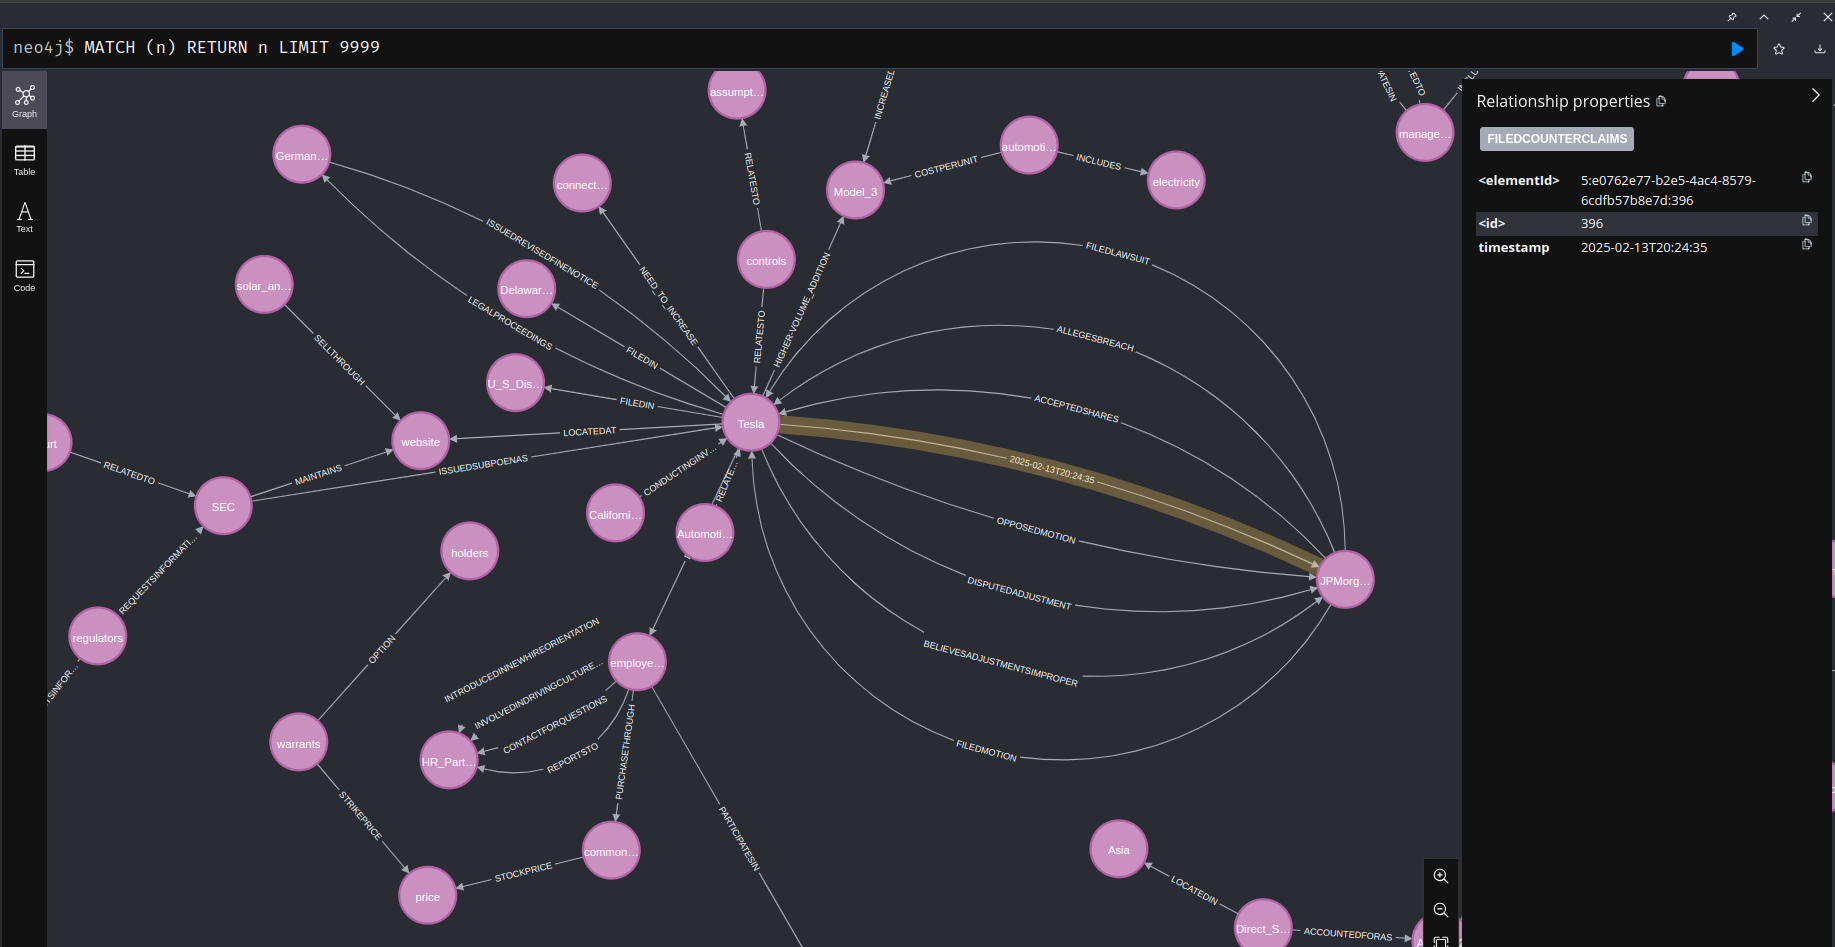

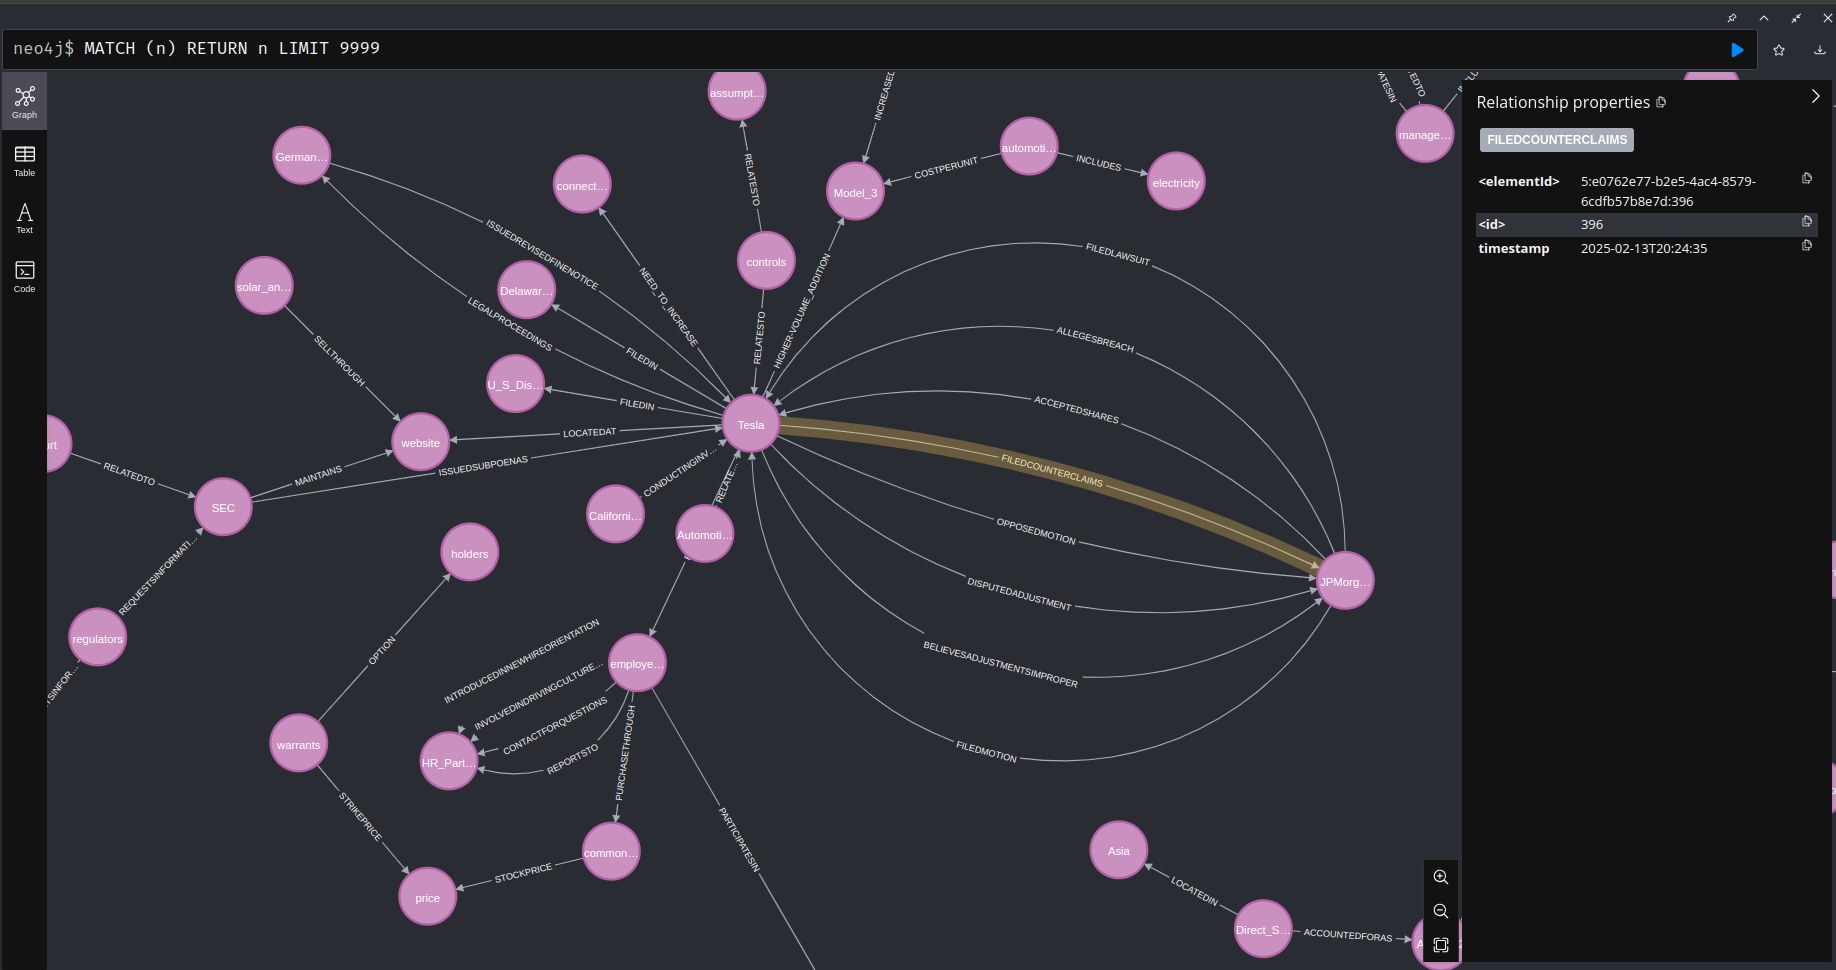

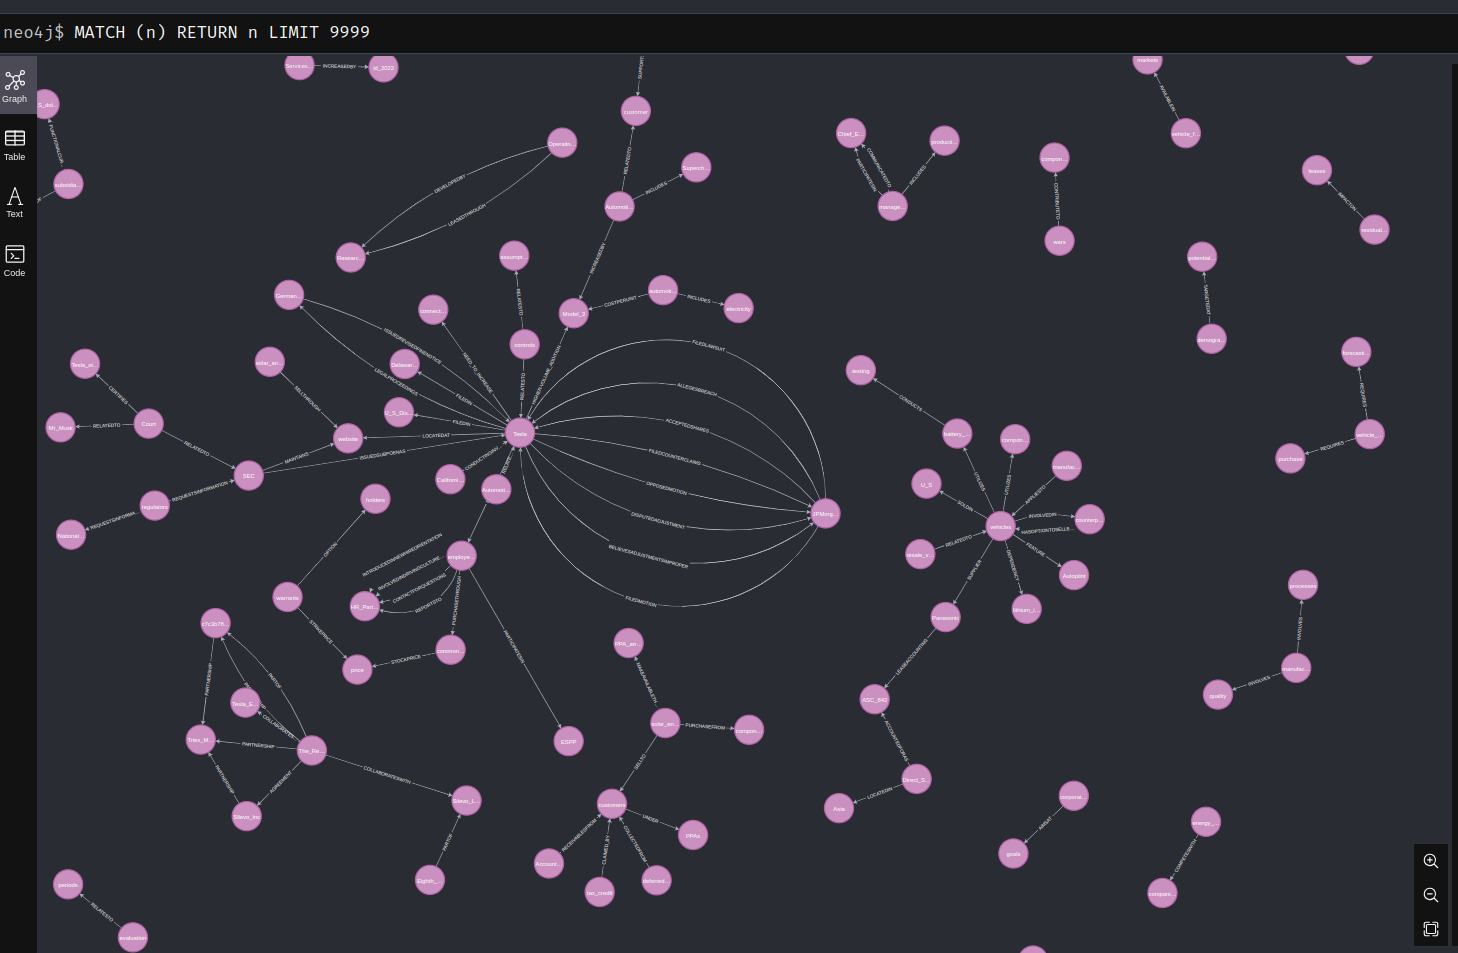


## 🔍 Querying the Knowledge Graph

Now that the knowledge graph is built, we can query it to retrieve time-based relationships.

In [ ]:
# Query all triplets
all_triplets = neo4j_graph.get_triplet()
if all_triplets:
    for triplet in all_triplets:
        print(
            f"Subject: {triplet['subj']}, Object: {triplet['obj']}, "
            f"Relationship: {triplet['rel']}, "
            f"Timestamp: {triplet['timestamp']}"
        )
else:
    print("No triplets found in the database.")

Subject: TSLA, Object: Rule_405, Relationship: COMPLIANCEWITH, Timestamp: 2025-02-13T19:41:26
Subject: Business_Risk_Factors, Object: Unresolved_Staff_Comments, Relationship: RELATEDTO, Timestamp: 2025-02-13T19:41:48
Subject: Business_Risk_Factors, Object: Properties, Relationship: RELATEDTO, Timestamp: 2025-02-13T19:41:48
Subject: solar_energy_systems, Object: customers, Relationship: SELLTO, Timestamp: 2025-02-13T19:42:30
Subject: solar_energy_systems, Object: PPA_arrangements, Relationship: MAKEAVAILABLETHROUGH, Timestamp: 2025-02-13T19:42:30
Subject: solar_energy_systems, Object: components, Relationship: PURCHASEFROM, Timestamp: 2025-02-13T19:42:30
Subject: vehicles, Object: battery_packs, Relationship: UTILIZES, Timestamp: 2025-02-13T19:42:39
Subject: vehicles, Object: component_level_technologies, Relationship: UTILIZES, Timestamp: 2025-02-13T19:43:00
Subject: used_vehicle_business, Object: customer, Relationship: SUPPORTS, Timestamp: 2025-02-13T19:43:22
Subject: solar_and_energ

## Parameters Investigation.

- `max_characters`: The maximum number of characters in a chunk.
- `model`: The model to use for the knowledge graph agent. (Mistral Large 2 or Samba Verse)

In [ ]:
elements = uio.parse_file_or_url(str(example_pdf_files[0]))
print(
    colorama.Fore.YELLOW
    + "The number of elements is: "
    + colorama.Fore.RESET
    + str(len(elements))
)

# Investigation of the chunk_elements function.
for max_characters in [512, 1024, 2048]:
    chunk_elements = uio.chunk_elements(
        elements,
        chunk_type="chunk_by_title",
        max_characters=max_characters,
    )
    print(
        colorama.Fore.BLUE
        + f"[max_characters: {max_characters:>4}] "
        + colorama.Fore.YELLOW
        + f"The number of chunk elements is: {len(chunk_elements)}"
        + colorama.Fore.RESET
    )

The number of elements is: 3889
[max_characters:  512] The number of chunk elements is: 1142
[max_characters: 1024] The number of chunk elements is: 568
[max_characters: 2048] The number of chunk elements is: 268


In [ ]:
limited_chunk_elements = uio.chunk_elements(
    elements, chunk_type="chunk_by_title", max_characters=1000
)
print(len(limited_chunk_elements))
print(limited_chunk_elements[0].text)

307
stocklight.com > Stocks > United States Apple > Annual Reports > 2021 Annual Report

Apple Annual Report 2021

Form 10-K (NASDAQ:AAPL)

Published: October 29th, 2021

Brought to you by

Year

2023

2022

2020

2019

2018

2017

2016

2015

2014

2013

2012

2011

2010

2010

2009

2008

2007

2006

2005

2004

2003

2002

Apple (AAPL) Historical Annual Reports 2002-2023

Report

Apple (AAPL) 10-K Annual Report - Nov 3rd, 2023

Apple (AAPL) 10-K Annual Report - Oct 28th, 2022

Apple (AAPL) 10-K Annual Report - Oct 30th, 2020

Apple (AAPL) 10-K Annual Report - Oct 31st, 2019

Apple (AAPL) 10-K Annual Report - Nov 5th, 2018

Apple (AAPL) 10-K Annual Report - Nov 3rd, 2017

Apple (AAPL) 10-K Annual Report - Oct 26th, 2016

Apple (AAPL) 10-K Annual Report - Oct 28th, 2015

Apple (AAPL) 10-K Annual Report - Oct 27th, 2014

Apple (AAPL) 10-K Annual Report - Oct 30th, 2013

Apple (AAPL) 10-K Annual Report - Oct 31st, 2012

Apple (AAPL) 10-K Annual Report - Oct 26th, 2011


In [ ]:
llama_kg_result = llama_405b_kg_agent.run(
    limited_chunk_elements[0], parse_graph_elements=True
)

In [ ]:
print(len(limited_chunk_elements[0].text))
print(limited_chunk_elements[0].text)

977
stocklight.com > Stocks > United States Apple > Annual Reports > 2021 Annual Report

Apple Annual Report 2021

Form 10-K (NASDAQ:AAPL)

Published: October 29th, 2021

Brought to you by

Year

2023

2022

2020

2019

2018

2017

2016

2015

2014

2013

2012

2011

2010

2010

2009

2008

2007

2006

2005

2004

2003

2002

Apple (AAPL) Historical Annual Reports 2002-2023

Report

Apple (AAPL) 10-K Annual Report - Nov 3rd, 2023

Apple (AAPL) 10-K Annual Report - Oct 28th, 2022

Apple (AAPL) 10-K Annual Report - Oct 30th, 2020

Apple (AAPL) 10-K Annual Report - Oct 31st, 2019

Apple (AAPL) 10-K Annual Report - Nov 5th, 2018

Apple (AAPL) 10-K Annual Report - Nov 3rd, 2017

Apple (AAPL) 10-K Annual Report - Oct 26th, 2016

Apple (AAPL) 10-K Annual Report - Oct 28th, 2015

Apple (AAPL) 10-K Annual Report - Oct 27th, 2014

Apple (AAPL) 10-K Annual Report - Oct 30th, 2013

Apple (AAPL) 10-K Annual Report - Oct 31st, 2012

Apple (AAPL) 10-K Annual Report - Oct 26th, 2011


In [ ]:
print(len(llama_kg_result.nodes))
print(llama_kg_result.nodes)

29
[Node(id='Apple', type='Organization', properties={'source': 'agent_created'}), Node(id='United States', type='Location', properties={'source': 'agent_created'}), Node(id='NASDAQ', type='Organization', properties={'source': 'agent_created'}), Node(id='AAPL', type='Stock', properties={'source': 'agent_created'}), Node(id='2021 Annual Report', type='Report', properties={'source': 'agent_created'}), Node(id='Form 10-K', type='ReportType', properties={'source': 'agent_created'}), Node(id='stocklight.com', type='Website', properties={'source': 'agent_created'}), Node(id='2023', type='Year', properties={'source': 'agent_created'}), Node(id='2022', type='Year', properties={'source': 'agent_created'}), Node(id='2020', type='Year', properties={'source': 'agent_created'}), Node(id='2019', type='Year', properties={'source': 'agent_created'}), Node(id='2018', type='Year', properties={'source': 'agent_created'}), Node(id='2017', type='Year', properties={'source': 'agent_created'}), Node(id='2016

## 🌟 Highlights

This notebook has guided you through setting up and running a dynamic knowledge graph construction workflow using CAMEL's Knowledge Graph Agent and Neo4j. You can adapt and expand this example for various other scenarios requiring dynamic graph generation and querying.

Key tools utilized in this notebook include:

- **CAMEL**: A powerful multi-agent framework that enables the construction of knowledge graphs from unstructured data.
- **Neo4j**: A graph database used to store and query the knowledge graph.
- **Mistral and SambaVerse Models**: Large language models used to generate the knowledge graph from parsed documents.
- **Deduplication**: Techniques to ensure the uniqueness of nodes and relationships in the graph.

This comprehensive setup allows you to adapt and expand the example for various scenarios requiring dynamic graph generation and querying.

<div class="align-center">
  <a href="https://www.camel-ai.org/"><img src="https://i.postimg.cc/KzQ5rfBC/button.png"width="150"></a>
  <a href="https://discord.camel-ai.org"><img src="https://i.postimg.cc/L4wPdG9N/join-2.png"  width="150"></a></a>
  
⭐ <i>Star us on [*Github*](https://github.com/camel-ai/camel), join our [*Discord*](https://discord.camel-ai.org) or follow our [*X*](https://x.com/camelaiorg)
</div>